/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['plain_text', 'published_date', 'title', 'tags', 'categories', 'author', 'sitename', 'publisher'],
        num_rows: 1200456
    })
})
{'plain_text': Value('string'), 'published_date': Value('string'), 'title': Value('string'), 'tags': Value('string'), 'categories': Value('string'), 'author': Value('string'), 'sitename': Value('string'), 'publisher': Value('string')}
Shape: (50000, 8)
Columns: ['plain_text', 'published_date', 'title', 'tags', 'categories', 'author', 'sitename', 'publisher']
Guessed columns -> DATE: None | TEXT: None | SOURCE: publisher
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   plain_text      50000 non-null  object
 1   published_date  50000 non-null  object
 2   title           50000 non-null  object
 3   tags            13217 non-null  object
 4   categories

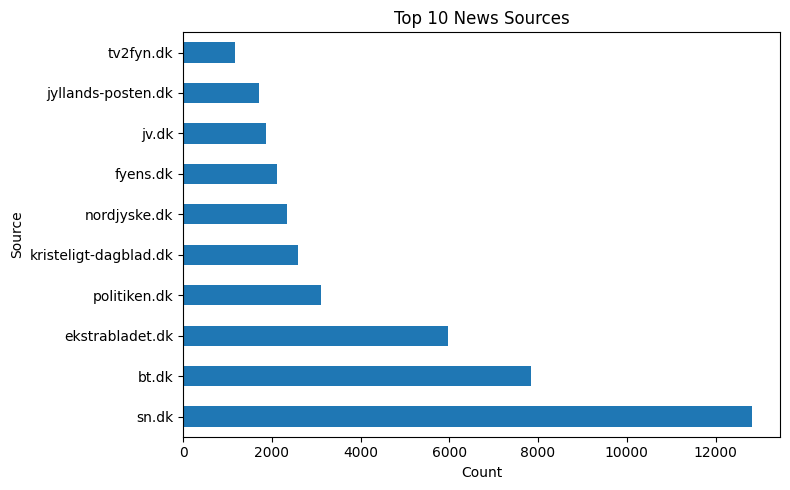

No text column found; skip length and token checks.


In [ ]:
# --- installs (Colab) ---
!pip -q install datasets pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# 1) Load HF dataset
ds = load_dataset("HamidBekam/dk_news_2016_2024")
print(ds)
print(ds['train'].features)

# 2) Selection of sample size (avoid loading oversized data at once)
SAMPLE_SIZE = 50000
train = ds['train']
if SAMPLE_SIZE and SAMPLE_SIZE < len(train):
    train = train.shuffle(seed=42).select(range(SAMPLE_SIZE))

# 3) output pandas DataFrame
df = pd.DataFrame(train)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

# 4) Intelligent guessing of column names (based on common naming)
def pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = set(df.columns)

DATE_COL   = pick_col(['date','published','publish_date','pub_date','time','datetime'], cols)
TEXT_COL   = pick_col(['content','text','article','body','full_text'], cols)
SOURCE_COL = pick_col(['source','domain','publisher','outlet','site','url_host'], cols)

print("Guessed columns -> DATE:", DATE_COL, "| TEXT:", TEXT_COL, "| SOURCE:", SOURCE_COL)


print(df.info())
print(df.describe(include='all'))


missing = df.isnull().sum().sort_values(ascending=False)
print("Top missing columns:\n", missing.head(10))

# 7) Time Distribution
if DATE_COL:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce', utc=True)
    df['year'] = df[DATE_COL].dt.year
    df['month'] = df[DATE_COL].dt.to_period('M').astype(str)

    plt.figure(figsize=(10,5))
    df['year'].value_counts().sort_index().plot(kind='bar')
    plt.title("News Count by Year (2016–2024)")
    plt.xlabel("Year"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

# 8) Source distribution
if SOURCE_COL:
    plt.figure(figsize=(8,5))
    df[SOURCE_COL].value_counts().head(10).plot(kind='barh')
    plt.title("Top 10 News Sources")
    plt.xlabel("Count"); plt.ylabel("Source")
    plt.tight_layout(); plt.show()

# 9) Distribution of text length (if there is a body column)
if TEXT_COL:
    df['text_len'] = df[TEXT_COL].astype(str).str.len()
    plt.figure(figsize=(8,5))
    sns.histplot(df['text_len'], bins=50)
    plt.title("Distribution of Text Lengths")
    plt.xlabel("Characters"); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

    # 10) A Primer on High Frequency Words (English/Latin Characters)
    from collections import Counter
    import re

    sample_texts = df[TEXT_COL].dropna().astype(str)
    sample_texts = sample_texts.sample(min(10000, len(sample_texts)), random_state=42)

    words = []
    for t in sample_texts:
        words += re.findall(r'\b[a-zA-Z]{3,}\b', t.lower())
    common = Counter(words).most_common(20)
    print("Top 20 tokens:", common)
else:
    print("No text column found; skip length and token checks.")

In [ ]:
import re

ai_keywords = [
    r"\bAI\b",
    r"\bartificial intelligence\b",
    r"\bmachine learning\b",
    r"\bdeep learning\b",
    r"\bneural network(s)?\b",
    r"\bautomation\b",
    r"\bchatgpt\b",
    r"\bopenai\b",
    r"\brobot(s|ics)?\b",
    r"\bkunstig intelligens\b",
    r"\bmaskinlæring\b"
]

pattern = "|".join(ai_keywords)
ai_df = df[df['plain_text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]
print(f"True AI-related articles: {len(ai_df)} out of {len(df)}")

/tmp/ipython-input-1969454039.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ai_df = df[df['plain_text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


True AI-related articles: 201 out of 50000


In [ ]:
import re

pattern = "|".join(ai_keywords)
ai_df = df[df['plain_text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

print(f"Total AI-related articles: {len(ai_df)} out of {len(df)}")
ai_df[['published_date', 'title', 'publisher']].head(10)

/tmp/ipython-input-1052625096.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ai_df = df[df['plain_text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


Total AI-related articles: 201 out of 50000


,published_date,title,publisher
339,2018-12-15,Russisk hi-tech robot var i virkeligheden mand...,politiken.dk
454,2023-10-04,Bruised Plug Power aktiekursen danner et falde...,invezz.com
839,2023-06-06,Lige indenfor: SEC sagsøger Coinbase for at fu...,invezz.com
1525,2017-10-16,KMD undgår endnu en millionbod til kommunerne:...,computerworld.dk
1598,2023-11-08,The Next Frontier in Robotics: How 5G Networks...,citylife.capetown
1977,2017-05-30,"Formand for Dansk Metal: ""Min frygt er, at vi ...",computerworld.dk
2340,2023-09-14,"EUR/USD-prognose: bearish signal, når et dødsk...",invezz.com
2616,2024-05-08,"Tyrkiet idømmer Meta en bøde på 37,2 millioner...",invezz.com
2700,2023-03-21,Paludan nægtet indrejse i Storbritannien efter...,kristeligt-dagblad.dk
2919,2021-01-25,"Dit ansigt kan afsløre om, du er højre- eller ...",ekstrabladet.dk


In [ ]:
# Check out some of the AI News body snippets
for i, row in ai_df[['published_date', 'title', 'plain_text', 'publisher']].sample(5, random_state=42).iterrows():
    print("="*80)
    print(f"📅 {row['published_date']} | 📰 {row['publisher']}")
    print(f"🧠 {row['title']}\n")
    print(row['plain_text'][:800])

📅 2024-01-24 | 📰 bilsektionen.dk
🧠 Golf 8 Facelift: 50-års Jubilæet for den ikoniske model - Bilsektionen.dk

Golf 8 Facelift: 50-års Jubilæet for Den Ikoniske Model  Volkswagen fejrer 50-års jubilæet for Golf med en imponerende opgradering af Golf 8, der blev præsenteret ved en verdenspremiere. Den nyeste version af Golf 8 byder på betydelige forbedringer, herunder ny hardware og software, opdateret design og avancerede drivlinjer med fokus på elektrisk mobilitet.  Ny Hardware og software  Golf 8 er nu udstyret med den nyeste generation af Volkswagens infotainmentsystemer, der praler af en hurtig processor, intuitiv betjening og en intelligent IDA-taleassistent. Den mest bemærkelsesværdige tilføjelse er integrationen af ChatGPT, en kunstig intelligens-baseret chatbot, der forbedrer brugeroplevelsen og tilbyder ubesværet adgang til en voksende database af information ved hjælp af naturligt sprog. 
📅 2018-08-28 | 📰 folkebladet.dk
🧠 Pilotprojekt ser på VVS og tilgængelighed

Et ungt par 

In [ ]:
!pip install deep-translator

from deep_translator import GoogleTranslator

# Example: translate 3 sample articles
for i, row in ai_df[['published_date', 'title', 'plain_text']].sample(3, random_state=42).iterrows():
    print("="*80)
    print(f"📅 {row['published_date']} | 🧠 {row['title']}\n")
    translated_text = GoogleTranslator(source='da', target='en').translate(row['plain_text'][:1000])
    print("🔹 English Translation:\n", translated_text)

📅 2024-01-24 | 🧠 Golf 8 Facelift: 50-års Jubilæet for den ikoniske model - Bilsektionen.dk

🔹 English Translation:
 Golf 8 Facelift: 50th Anniversary of the Iconic Model Volkswagen is celebrating the 50th anniversary of the Golf with an impressive upgrade of the Golf 8 presented at a world premiere. The latest version of the Golf 8 offers significant improvements, including new hardware and software, updated design and advanced powertrains with a focus on electric mobility.  New Hardware and software The Golf 8 is now equipped with the latest generation of Volkswagen's infotainment systems, boasting a fast processor, intuitive operation and an intelligent IDA voice assistant. The most notable addition is the integration of ChatGPT, an artificial intelligence-based chatbot that enhances the user experience and offers effortless access to a growing database of information using natural language.  New Plug-in Hybrid Powertrain The Golf 8 introduces a new plug-in hybrid powertrain with a p

In [ ]:
#Using a pre-trained semantic model (e.g., paraphrase-multilingual-MiniLM-L12-v2),
#the similarity between each article and the semantics of "AI technology" was calculated, and only the highly similar ones were retained.
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

query = "This article discusses artificial intelligence, machine learning, or AI technologies."
query_emb = model.encode(query, convert_to_tensor=True)

embeddings = model.encode(ai_df['plain_text'].tolist(), convert_to_tensor=True)
scores = util.cos_sim(query_emb, embeddings)[0]

ai_df = ai_df.copy()  # avoid warning
ai_df['ai_similarity'] = scores.cpu().numpy()

filtered_df_04 = ai_df[ai_df['ai_similarity'] > 0.4].copy()
filtered_df_03 = ai_df[ai_df['ai_similarity'] > 0.3].copy()
filtered_df_025 = ai_df[ai_df['ai_similarity'] > 0.25].copy()

print(" > 0.4  :", len(filtered_df_04))
print(" > 0.3  :", len(filtered_df_03))
print(" > 0.25 :", len(filtered_df_025))

 > 0.4  : 29
 > 0.3  : 50
 > 0.25 : 73


In [ ]:
filtered_04 = ai_df[ai_df['ai_similarity'] > 0.40].copy()
filtered_03 = ai_df[ai_df['ai_similarity'] > 0.30].copy()

filtered_04.to_csv("AI_articles_high_precision_0.40.csv", index=False)
filtered_03.to_csv("AI_articles_high_recall_0.30.csv", index=False)

print("Saved both datasets!")

Saved both datasets!


To balance precision and recall, we construct two semantic subsets.
A high-precision corpus (similarity > 0.40, N=29) is used for narrative framing analysis, while a high-recall corpus (similarity > 0.30, N=50) is used for topic modeling and temporal trend visualization.

In [ ]:
sample_rows = filtered_df_03.sample(5, random_state=42)[['published_date','title','plain_text']]
sample_rows

,published_date,title,plain_text
14606,2024-06-04,Millionærklubben: Fremtiden med AI,Se udsendelsen ovenover. Hvordan ser fremtide...
39805,2024-06-06,Få hjælp af Nvidias nye in-game chatbot,Snart vil alle med et Nvidia-grafikkort have a...
30037,2023-03-30,Goldman Sachs: Ny teknologi kan ramme 300 mill...,"Hov, giv os lov at afspille artiklen. Den er k..."
44319,2023-05-17,Ny teknologi rummer både muligheder og udfordr...,"Teknologi »Forventningen er, at systemet vil k..."
18717,2021-08-17,Støvsugning og gulvvask med smart robotstøvsuger,"Mi Robot Vacuum Mop Essential er en alsidig, h..."


In [ ]:
translation_dict = {
    "kan": "can",
    "intelligens": "intelligence",
    "ved": "know / by",
    "kunstig": "artificial",
    "mere": "more",
    "siger": "says",
    "apple": "Apple",
    "nye": "new",
    "flere": "more / several",
    "teknologi": "technology",
    "kun": "only",
    "robotten": "the robot",
    "robot": "robot",
    "andre": "others",
    "vores": "our",
    "data": "data",
    "hvordan": "how",
    "tid": "time",
    "google": "Google",
    "ifølge": "according to",
    "bruge": "use",
    "store": "large",
    "inden": "within / before",
    "helt": "completely",
    "derfor": "therefore",
    "kommer": "comes",
    "procent": "percent",
    "børn": "children",
    "får": "gets",
    "patienter": "patients",
    "hele": "whole",
    "hjælpe": "help",
    "microsoft": "Microsoft",
    "hvilket": "which",
    "cloud": "cloud",
    "første": "first",
    "både": "both",
    "openai": "OpenAI",
    "bedre": "better",
    "blevet": "has become",
    "virksomheder": "companies",
    "virksomheden": "the company",
    "mens": "while",
    "teknologien": "the technology",
    "stor": "large",
    "brug": "use",
    "gøre": "do / make",
    "pro": "pro (device series)",
    "billeder": "images",
    "gør": "does"
}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# set stop words
danish_stopwords = [
    "og","i","jeg","det","at","en","den","til","er","som","på","de","med","han",
    "af","for","ikke","der","var","mig","sig","men","et","har","om","vi","min",
    "havde","ham","hun","nu","over","da","fra","du","ud","sin","dem","os",
    "op","man","hans","hvor","eller","hvad","skal","selv","her","alle","vil",
    "blev","kunne","ind","når","være","dog","noget","ville","jo","deres","efter",
    "ned","skulle","denne","end","dette","mit","også","under","have","dig",
    "anden","hende","mine","alt","meget","sit","sine","vor","mod","disse",
    "hvis","din","nogle","hos","blive","mange","ad","bliver","hendes","været",
    "thi","jer","sådan"
]


extra_noise = [
    "kan","mere","flere","siger","ved","hvordan","tid","bruge","store","andre",
    "vores","helt","kommer","derfor","får","gør","mens","første","både","kun",
    "børn","helt","inden","hvornår","virkelig","gange","lige","før",
]

# Extended stop words
danish_stopwords_extended = danish_stopwords + extra_noise
# 2. clean text
filtered_df_03['clean_text'] = filtered_df_03['plain_text'].fillna("").astype(str)

# 3. CountVectorizer：Keep only words with "at least 3 letters" (no pure numbers).
#   token_pattern ：
#   (?u)         →  unicode
#   \b           → Word boundary
#   [^\d\W]{3,}  → At least 3 non-numeric letters (excluding 000, 2019, etc.)
#   \b           → Word boundary
vectorizer = CountVectorizer(
    stop_words=danish_stopwords,
    token_pattern=r'(?u)\b[^\d\W]{3,}\b',
    max_features=5000   # Grab 5000 features and pick top 50 from them
)

X = vectorizer.fit_transform(filtered_df_03['clean_text'])

# 4. Calculate the total number of occurrences of each word in the entire corpus
word_counts = np.asarray(X.sum(axis=0)).ravel()
vocab = np.array(vectorizer.get_feature_names_out())

# 5. Selection of the 50 most frequent words
top_idx = word_counts.argsort()[::-1][:50]
top_words = list(zip(vocab[top_idx], word_counts[top_idx]))

print("Top 50 content words in Danish AI articles (word, count):")
for w, c in top_words:
    print(f"{w:20s} {c}")

Top 50 content words in Danish AI articles (word, count):
kan                  161
intelligens          57
ved                  53
kunstig              52
mere                 50
siger                48
apple                36
nye                  36
flere                33
teknologi            31
kun                  29
robotten             29
robot                28
andre                27
vores                27
data                 24
hvordan              24
tid                  24
google               24
ifølge               23
bruge                22
store                22
inden                20
helt                 20
derfor               19
kommer               19
procent              19
børn                 19
får                  19
patienter            18
hele                 18
hjælpe               18
microsoft            17
hvilket              17
cloud                16
første               16
både                 16
openai               16
bedre                16
bleve

In [ ]:
df_keywords = pd.DataFrame(top_words, columns=["danish_word", "count"])

In [ ]:
df_keywords["english_translation"] = df_keywords["danish_word"].map(translation_dict)
df_keywords

,danish_word,count,english_translation
0,kan,161,can
1,intelligens,57,intelligence
2,ved,53,know / by
3,kunstig,52,artificial
4,mere,50,more
5,siger,48,says
6,apple,36,Apple
7,nye,36,new
8,flere,33,more / several
9,teknologi,31,technology
